---
title: sklearn and Gradient Descent (Fall 2025)
---

::: {note} Learning Outcomes
* Apply the `sklearn` library for model creation and training
* Optimizing complex models 
* Identifying cases where straight calculus or geometric arguments won't help solve the loss function
* Applying gradient descent for numerical optimization
:::

In [1]:
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
pd.options.mode.chained_assignment = None  # default='warn'

## OLS Recap

### 1. Choose a model
Recall that when using multiple linear regression, we can generate a prediction for each of our $n$ data points:

$$\hat{y} =\theta_{0} + \theta_{1}x_{1} + \theta_{2}x_{2} + ... + \theta_{p}x_{p}$$

```{image} images/ols_matrices_old.png
:alt: How to use ordinary least squares to generate predictions.
:width: 600
```

In the previous lecture, we used p+1 features to account for the intercept, $\theta_0$.  This makes slides and notation messy.  
Let’s redefine **p as the number of columns in our covariate matrix** and **add a column of 1s** to encode the intercept (if desired). If we choose to add a column of 1s, then $x_1$ can be a 1 for every data point.

$$\hat{y} =\theta_{1}x_{1} + \theta_{2}x_{2} + ... + \theta_{p}x_{p}$$

```{image} images/ols_matrices_new.png
:alt:"" 
:width: 600
```

### 2. Choose a loss function

Recall that we then choose the mean squared error loss function shown below where the prediction vector $\hat{\mathbb{Y}}$ depends on $\theta$.
$$R(\theta) = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2 = \frac{1}{n} (||\mathbb{Y} - \hat{\mathbb{Y}}||_2)^2$$

### 3. Fit the model

We can then minimize the average loss with calculus or geometry. See the previous lecture for a derivation on the Normal Equation ($\mathbb{X}^T \mathbb{X} \hat{\theta} = \mathbb{X}^T \mathbb{Y}$) using geometry. We can see what the matrices look like with our new interpretation where $\mathbb{X}$ is now an $n$ by $p$ matrix instead of an $n$ by $p+1$ matrix.

```{image} images/ols_solution_matrices.png
:alt: Visual representation of the normal equation
:width: 400 
```

To summarize:

|   | Model | Estimate | Unique? |
| -- | -- | -- |  -- | 
| Constant Model + MSE | $\hat{y} = \theta_0$| $\hat{\theta}_0 = mean(y) = \bar{y}$ | **Yes**. Any set of values has a unique mean.
| Constant Model + MAE | $\hat{y} = \theta_0$  | $\hat{\theta}_0 = median(y)$ | **Yes**, if odd. **No**, if even. Return the average of the middle 2 values.
| Simple Linear Regression + MSE | $\hat{y} = \theta_0 + \theta_1x$| $\hat{\theta}_0 = \bar{y} - \hat{\theta}_1\bar{x}$ $\hat{\theta}_1 = r\frac{\sigma_y}{\sigma_x}$| **Yes**. Any set of non-constant* values has a unique mean, SD, and correlation coefficient.
| **OLS** (Linear Model + MSE) | $\mathbb{\hat{Y}} = \mathbb{X}\mathbb{\theta}$| $\hat{\theta} = (\mathbb{X}^T\mathbb{X})^{-1}\mathbb{X}^T\mathbb{Y}$  | **Yes**, if $\mathbb{X}$ is full column rank (all columns are linearly independent, # of datapoints >>> # of features).

#### Uniqueness of a Solution

In most settings, the number of observations ($n$) is much greater than the number of features ($p$). Note that at least one solution always exists because intuitively, we can always draw a line of best fit for a given set of data, but there may be multiple lines that are “equally good”. (Formal proof is beyond this course.) Let's now revisit the interpretation for uniqueness of a solution at the end of the last lecture, but with the new notation of $p$ instead of $p+1$ features.

The Least Squares estimate $\hat{\theta}$ is **unique** if and only if $\mathbb{X}$ is **full column rank**.

::: {tip} Proof

* We know the solution to the normal equation $\mathbb{X}^T\mathbb{X}\hat{\theta} = \mathbb{X}^T\mathbb{Y}$ is the least square estimate that minimizes the squared loss.
* $\hat{\theta}$ has a **unique** solution $\iff$ the square matrix $\mathbb{X}^T\mathbb{X}$ is **invertible** $\iff$ $\mathbb{X}^T\mathbb{X}$ is full rank.
  * The **column rank** of a square matrix is the max number of linearly independent columns it contains.
  * An $n$ x $n$ square matrix is deemed full column rank when all of its columns are linearly independent. That is, its rank would be equal to $n$.
  * $\mathbb{X}^T\mathbb{X}$ has shape $p \times p$, and therefore has max rank $p$. 
* $rank(\mathbb{X}^T\mathbb{X})$ = $rank(\mathbb{X})$ (proof out of scope).
* Therefore, $\mathbb{X}^T\mathbb{X}$ has rank $p$ $\iff$  $\mathbb{X}$ has rank $p$ $\iff \mathbb{X}$ is full column rank.
:::

Therefore, if $\mathbb{X}$ is not full column rank, we will not have unique estimates. This can happen for two major reasons.

1. If our design matrix $\mathbb{X}$ is "**wide**":
    * If n < p, then we have way more features (columns) than observations (rows).
    * Then $rank(\mathbb{X})$ = min(n, p) < p, so $\hat{\theta}$ is not unique.
    * Typically we have n >> p so this is less of an issue.

2. If our design matrix $\mathbb{X}$ has features that are **linear combinations** of other features:
    * By definition, rank of $\mathbb{X}$ is number of linearly independent columns in $\mathbb{X}$.
    * Example: If “Width”, “Height”, and “Perimeter” are all columns,
      * Perimeter = 2 * Width + 2 * Height  $\rightarrow$  $\mathbb{X}$ is not full rank.
    * Important with one-hot encoding (to discuss later).


Let's now explore how to use the normal equations with a real-world dataset in the next section.

## `sklearn`
### Implementing Derived Formulas in Code

Throughout this lecture, we'll refer to the `penguins` dataset. 

````{dropdown} Click to see the code
```python
import pandas as pd
import seaborn as sns
import numpy as np

penguins = sns.load_dataset("penguins")
penguins = penguins[penguins["species"] == "Adelie"].dropna()
penguins.head()
```
````

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np

penguins = sns.load_dataset("penguins")
penguins = penguins[penguins["species"] == "Adelie"].dropna()
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


Our goal will be to predict the value of the `"bill_depth_mm"` for a particular penguin given its `"flipper_length_mm"` and `"body_mass_g"`. We'll also add a bias column of all ones to represent the intercept term of our models.

In [3]:
# Add a bias column of all ones to `penguins`
penguins["bias"] = np.ones(len(penguins), dtype=int) 

# Define the design matrix, X...
# Note that we use .to_numpy() to convert our DataFrame into a NumPy array so it is in Matrix form
X = penguins[["bias", "flipper_length_mm", "body_mass_g"]].to_numpy()

# ...as well as the target variable, Y
# Again, we use .to_numpy() to convert our DataFrame into a NumPy array so it is in Matrix form
Y = penguins[["bill_depth_mm"]].to_numpy()

In the lecture on ordinary least squares, we expressed multiple linear regression using matrix notation.

$$\hat{\mathbb{Y}} = \mathbb{X}\theta$$

We used a geometric approach to derive the following expression for the optimal model parameters:

$$\hat{\theta} = (\mathbb{X}^T \mathbb{X})^{-1}\mathbb{X}^T \mathbb{Y}$$

That's a whole lot of matrix manipulation. How do we implement it in `python`?

There are three operations we need to perform here: multiplying matrices, taking transposes, and finding inverses. 

* To perform matrix multiplication, use the `@` operator
* To take a transpose, call the `.T` attribute of an `NumPy` array or `DataFrame`
* To compute an inverse, use `NumPy`'s in-built method `np.linalg.inv`

Putting this all together, we can compute the OLS estimate for the optimal model parameters, stored in the array `theta_hat`.

In [4]:
theta_hat = np.linalg.inv(X.T @ X) @ X.T @ Y
theta_hat

array([[1.10029953e+01],
       [9.82848689e-03],
       [1.47749591e-03]])

To make predictions using our optimized parameter values, we matrix-multiply the design matrix with the parameter vector:

$$\hat{\mathbb{Y}} = \mathbb{X}\theta$$

In [5]:
Y_hat = X @ theta_hat
pd.DataFrame(Y_hat).head()

,0
0,18.322561
1,18.445578
2,17.721412
3,17.997254
4,18.263268


### The `sklearn` Workflow
We've already saved a lot of time (and avoided tedious calculations) by translating our derived formulas into code. However, we still had to go through the process of writing out the linear algebra ourselves. 

To make life *even easier*, we can turn to the `sklearn` `python` [library](https://scikit-learn.org/stable/). `sklearn` is a robust library of machine learning tools used extensively in research and industry. It is the standard for simple machine learning tasks and gives us a wide variety of in-built modeling frameworks and methods, so we'll keep returning to `sklearn` techniques as we progress through Data 100. 

Regardless of the specific type of model being implemented, `sklearn` follows a standard set of steps for creating a model: 

1. Import the `LinearRegression` model from `sklearn`

    ```python
    from sklearn.linear_model import LinearRegression
    ```

2. Create a model object. This generates a new instance of the model class. You can think of it as making a new "copy" of a standard "template" for a model. In code, this looks like:

    ```python
    my_model = LinearRegression()
    ```

    
3. Fit the model to the `X` design matrix and `Y` target vector. This calculates the optimal model parameters "behind the scenes" without us explicitly working through the calculations ourselves. The fitted parameters are then stored within the model for use in future predictions:

    ```python
    my_model.fit(X, Y)
     ```

    
4. Use the fitted model to make predictions on the `X` input data using `.predict`. 

    ```python
    my_model.predict(X)
    ```

To extract the fitted parameters, we can use:

  ```python
  my_model.coef_

  my_model.intercept_
  ```


Let's put this into action with our multiple regression task!

**1. Initialize an instance of the model class**

`sklearn` stores "templates" of useful models for machine learning. We begin the modeling process by making a "copy" of one of these templates for our own use. Model initialization looks like `ModelClass()`, where `ModelClass` is the type of model we wish to create.

For now, let's create a linear regression model using `LinearRegression`. 

`my_model` is now an instance of the `LinearRegression` class. You can think of it as the "idea" of a linear regression model. We haven't trained it yet, so it doesn't know any model parameters and cannot be used to make predictions. In fact, we haven't even told it what data to use for modeling! It simply waits for further instructions.


In [6]:
my_model = LinearRegression()

**2. Train the model using `.fit`**

Before the model can make predictions, we will need to fit it to our training data. When we fit the model, `sklearn` will run gradient descent behind the scenes to determine the optimal model parameters. It will then save these model parameters to our model instance for future use. 

All `sklearn` model classes include a `.fit` method, which is used to fit the model. It takes in two inputs: the design matrix, `X`, and the target variable, `Y`. 

Let's start by fitting a model with just one feature: the flipper length. We create a design matrix `X` by pulling out the `"flipper_length_mm"` column from the `DataFrame`. 

In [7]:
# .fit expects a 2D data design matrix, so we use double brackets to extract a DataFrame
X = penguins[["flipper_length_mm"]]
Y = penguins["bill_depth_mm"]

my_model.fit(X, Y)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


Notice that we use **double brackets** to extract this column. Why double brackets instead of just single brackets? The `.fit` method, by default, expects to receive **2-dimensional** data – some kind of data that includes both rows and columns. Writing `penguins["flipper_length_mm"]` would return a 1D `Series`, causing `sklearn` to error. We avoid this by writing `penguins[["flipper_length_mm"]]` to produce a 2D `DataFrame`. 

And in just three lines of code, our model has run gradient descent to determine the optimal model parameters! Our single-feature model takes the form:

$$\text{bill depth} = \theta_0 + \theta_1 \text{flipper length}$$

Note that `LinearRegression` will automatically include an intercept term. 

The fitted model parameters are stored as attributes of the model instance. `my_model.intercept_` will return the value of $\hat{\theta}_0$ as a scalar. `my_model.coef_` will return all values $\hat{\theta}_1, 
\hat{\theta}_2, ...$ in an array. Because our model only contains one feature, we see just the value of $\hat{\theta}_1$ in the cell below.

In [8]:
# The intercept term, theta_0
my_model.intercept_

7.297305899612299

In [9]:
# All parameters theta_1, ..., theta_p
my_model.coef_

array([0.05812622])

**3. Use the fitted model to make predictions**

Now that the model has been trained, we can use it to make predictions! To do so, we use the `.predict` method. `.predict` takes in one argument: the design matrix that should be used to generate predictions. To understand how the model performs on the training set, we would pass in the training data. Alternatively, to make predictions on unseen data, we would pass in a new dataset that wasn't used to train the model.

Below, we call `.predict` to generate model predictions on the original training data. As before, we use double brackets to ensure that we extract 2-dimensional data.

In [10]:
Y_hat_one_feature = my_model.predict(penguins[["flipper_length_mm"]])
Y_hat_one_feature[:10]

array([17.81815239, 18.10878351, 18.63191952, 18.51566707, 18.3412884 ,
       17.81815239, 18.63191952, 17.87627861, 18.39941463, 18.80629819])

The `sklearn` package also provides a function `mean_squared_error()` [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) that computes the MSE from a list of observations and predictions. This avoids us having to manually compute MSE by first computing residuals.

In [11]:
from sklearn.metrics import mean_squared_error
print(f"The MSE of the model is {mean_squared_error(Y, Y_hat_one_feature)}")

The MSE of the model is 1.333877879980637


What if we wanted a model with two features? 

$$\text{bill depth} = \theta_0 + \theta_1 \text{flipper length} + \theta_2 \text{body mass}$$

We repeat this three-step process by intializing a new model object, then calling `.fit` and `.predict` as before.

In [12]:
# Step 1: initialize LinearRegression model
two_feature_model = LinearRegression()

# Step 2: fit the model
X_two_features = penguins[["flipper_length_mm", "body_mass_g"]]
Y = penguins["bill_depth_mm"]

two_feature_model.fit(X_two_features, Y)

# Step 3: make predictions
Y_hat_two_features = two_feature_model.predict(X_two_features)

print(f"The MSE of the model is {mean_squared_error(Y, Y_hat_two_features)}")

The MSE of the model is 0.9764070438844


We can also see that we obtain the same predictions using `sklearn` as we did when applying the ordinary least squares formula before! 

In [13]:
pd.DataFrame({"Y_hat from OLS":np.squeeze(Y_hat), "Y_hat from sklearn":Y_hat_two_features}).head()

,Y_hat from OLS,Y_hat from sklearn
0,18.322561,18.322561
1,18.445578,18.445578
2,17.721412,17.721412
3,17.997254,17.997254
4,18.263268,18.263268


## Gradient Descent 

At this point, we've grown quite familiar with the process of choosing a model and a corresponding loss function and optimizing parameters by choosing the values of $\theta$ that minimize the loss function. So far, we've optimized $\theta$ by

1. Using calculus to take the derivative of the loss function with respect to $\theta$, setting it equal to 0, and solving for $\theta$.
2. Using the geometric argument of orthogonality to derive the OLS solution $\hat{\theta} = (\mathbb{X}^T \mathbb{X})^{-1}\mathbb{X}^T \mathbb{Y}$.

One thing to note, however, is that the techniques we used above can only be applied if we make some big assumptions. For the calculus approach, we assumed that the loss function was differentiable at all points and that we could algebraically solve for the zero points of the derivative; for the geometric approach, OLS *only* applies when using a linear model with MSE loss. What happens when we have more complex models with different, more complex loss functions? The techniques we've learned so far will not work, so we need a new optimization technique: **gradient descent**. 

> **BIG IDEA**: use an iterative algorithm to numerically compute the minimum of the loss.

### Minimizing an Arbitrary 1D Function

Let's consider an arbitrary function. Our goal is to find the value of $x$ that minimizes this function.

In [14]:
def arbitrary(x):
    return (x**4 - 15*x**3 + 80*x**2 - 180*x + 144)/10

```{image} images/arbitrary.png
:alt: The arbitrary function is plotted with the minimum annotated.
:width: 600
```

#### The Naive Approach: Guess and Check

Above, we saw that the minimum is somewhere around 5.3. Let's see if we can figure out how to find the exact minimum algorithmically from scratch. One very slow (and terrible) way would be manual guess-and-check.

In [15]:
arbitrary(6)

0.0

A somewhat better (but still slow) approach is to use brute force to try out a bunch of x values and return the one that yields the lowest loss.

In [16]:
def simple_minimize(f, xs):
    # Takes in a function f and a set of values xs. 
    # Calculates the value of the function f at all values x in xs
    # Takes the minimum value of f(x) and returns the corresponding value x 
    y = [f(x) for x in xs]  
    return xs[np.argmin(y)]

guesses = [5.3, 5.31, 5.32, 5.33, 5.34, 5.35]
simple_minimize(arbitrary, guesses)

5.33

This process is essentially the same as before where we made a graphical plot, it's just that we're only looking at 20 selected points.

````{dropdown} Click to see the code
```python
xs = np.linspace(1, 7, 200)
sparse_xs = np.linspace(1, 7, 5)

ys = arbitrary(xs)
sparse_ys = arbitrary(sparse_xs)

fig = px.line(x = xs, y = arbitrary(xs))
fig.add_scatter(x = sparse_xs, y = arbitrary(sparse_xs), mode = "markers")
fig.update_layout(showlegend= False)
fig.update_layout(autosize=False, width=800, height=600)
fig.show()
```
````

In [17]:
xs = np.linspace(1, 7, 200)
sparse_xs = np.linspace(1, 7, 5)

ys = arbitrary(xs)
sparse_ys = arbitrary(sparse_xs)

fig = px.line(x = xs, y = arbitrary(xs))
fig.add_scatter(x = sparse_xs, y = arbitrary(sparse_xs), mode = "markers")
fig.update_layout(showlegend= False)
fig.update_layout(autosize=False, width=800, height=600)
fig.show()

This basic approach suffers from three major flaws:

1. If the minimum is outside our range of guesses, the answer will be completely wrong.
2. Even if our range of guesses is correct, if the guesses are too coarse, our answer will be inaccurate.
3. It is *very* computationally inefficient, considering potentially vast numbers of guesses that are useless.

#### `Scipy.optimize.minimize`

One way to minimize this mathematical function is to use the `scipy.optimize.minimize` function. It takes a function and a starting guess and tries to find the minimum.

In [18]:
from scipy.optimize import minimize

# takes a function f and a starting point x0 and returns a readout 
# with the optimal input value of x which minimizes f
minimize(arbitrary, x0 = 3.5)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -0.13827491292966557
        x: [ 2.393e+00]
      nit: 3
      jac: [ 6.486e-06]
 hess_inv: [[ 7.385e-01]]
     nfev: 20
     njev: 10

`scipy.optimize.minimize` is great. It may also seem a bit magical. How could you write a function that can find the minimum of any mathematical function? There are a number of ways to do this, which we'll explore in today's lecture, eventually arriving at the important idea of **gradient descent**, which is the principle that `scipy.optimize.minimize` uses.

It turns out that under the hood, the `fit` method for `LinearRegression` models uses gradient descent. Gradient descent is also how much of machine learning works, including even advanced neural network models. 

In Data 100, the gradient descent process will usually be invisible to us, hidden beneath an abstraction layer. However, to be good data scientists, it's important that we know the underlying principles that optimization functions harness to find optimal parameters.


#### Digging into Gradient Descent
Looking at the function across this domain, it is clear that the function's minimum value occurs around $\theta = 5.3$. Let's pretend for a moment that we *couldn't* see the full view of the cost function. How would we guess the value of $\theta$ that minimizes the function? 

It turns out that the first derivative of the function can give us a clue. In the graph below, the function and its derivative are plotted, with points where the derivative is equal to 0 plotted in light green.

````{dropdown} Click to see the code
```python
import plotly.graph_objects as go

def derivative_arbitrary(x):
    return (4*x**3 - 45*x**2 + 160*x - 180)/10

fig = go.Figure()
roots = np.array([2.3927, 3.5309, 5.3263])

fig.add_trace(go.Scatter(x = xs, y = arbitrary(xs), 
                         mode = "lines", name = "f"))
fig.add_trace(go.Scatter(x = xs, y = derivative_arbitrary(xs), 
                         mode = "lines", name = "df", line = {"dash": "dash"}))
fig.add_trace(go.Scatter(x = np.array(roots), y = 0*roots, 
                         mode = "markers", name = "df = zero", marker_size = 12))
fig.update_layout(font_size = 20, yaxis_range=[-1, 3])
fig.update_layout(autosize=False, width=800, height=600)
fig.show()
```
````

In [19]:
import plotly.graph_objects as go

def derivative_arbitrary(x):
    return (4*x**3 - 45*x**2 + 160*x - 180)/10

fig = go.Figure()
roots = np.array([2.3927, 3.5309, 5.3263])

fig.add_trace(go.Scatter(x = xs, y = arbitrary(xs), 
                         mode = "lines", name = "f"))
fig.add_trace(go.Scatter(x = xs, y = derivative_arbitrary(xs), 
                         mode = "lines", name = "df", line = {"dash": "dash"}))
fig.add_trace(go.Scatter(x = np.array(roots), y = 0*roots, 
                         mode = "markers", name = "df = zero", marker_size = 12))
fig.update_layout(font_size = 20, yaxis_range=[-1, 3])
fig.update_layout(autosize=False, width=800, height=600)
fig.show()

In the plots below, the line indicates the value of the derivative of each value of $\theta$. The derivative is negative where it is red and positive where it is green.


Say we make a guess for the minimizing value of $\theta$. Remember that we read plots from left to right, and assume that our starting $\theta$ value is to the left of the optimal $\hat{\theta}$. If the guess "undershoots" the true minimizing value – our guess for $\theta$ is lower than the value of the $\hat{\theta}$ that minimizes the function – the derivative will be **negative**. This means that if we increase $\theta$ (move further to the right), then we **can decrease** our loss function further. If this guess "overshoots" the true minimizing value, the derivative will be positive, implying the converse.

```{image} images/step.png
:alt: Graphs showing overshooting and undershooting.
:width: 600
```

We can use this pattern to help formulate our next guess for the optimal $\hat{\theta}$. Consider the case where we've undershot $\theta$ by guessing too low of a value. We'll want our next guess to be greater in value than our previous guess – that is, we want to shift our guess to the right. You can think of this as following the slope "downhill" to the function's minimum value.

```{image} images/neg_step.png
:alt: Graphs showing an undershot guess and then an updated guess
:width: 600
```

If we've overshot $\hat{\theta}$ by guessing too high of a value, we'll want our next guess to be lower in value – we want to shift our guess for $\hat{\theta}$ to the left. 

```{image} images/pos_step.png
:alt: Graphs showing an overshot guess and then an updated guess
:width: 600
```

In other words, the derivative of the function at each point tells us the direction of our next guess.

* A negative slope means we want to step to the right, or move in the *positive* direction. 
* A positive slope means we want to step to the left, or move in the *negative* direction.

#### Algorithm Attempt 1
Armed with this knowledge, let's try to see if we can use the derivative to optimize the function.

We start by making some guess for the minimizing value of $x$. Then, we look at the derivative of the function at this value of $x$, and step downhill in the *opposite* direction. We can express our new rule as a recurrence relation:

$$x^{(t+1)} = x^{(t)} - \frac{d}{dx} f(x^{(t)})$$

Translating this statement into English: we obtain **our next guess** for the minimizing value of $x$ at timestep $t+1$ ($x^{(t+1)}$) by taking **our last guess** ($x^{(t)}$) and subtracting the **derivative of the function** at that point ($\frac{d}{dx} f(x^{(t)})$).

A few steps are shown below, where the old step is shown as a transparent point, and the next step taken is the green-filled dot.

```{image} images/grad_descent_1.png
:alt: ""
```

Looking pretty good! We do have a problem though – once we arrive close to the minimum value of the function, our guesses "bounce" back and forth past the minimum without ever reaching it.

```{image} images/grad_descent_2.png
:alt: ""
```

In other words, each step we take when updating our guess moves us too far. We can address this by decreasing the size of each step. 

#### Algorithm Attempt 2
Let's update our algorithm to use a **learning rate** (also sometimes called the step size), which controls how far we move with each update. We represent the learning rate with $\alpha$. 

$$x^{(t+1)} = x^{(t)} - \alpha \frac{d}{dx} f(x^{(t)})$$

A small $\alpha$ means that we will take small steps; a large $\alpha$ means we will take large steps. When do we stop updating? We stop updating either after a fixed number of updates or after a subsequent update doesn't change much.

::: {note}

In Data 100, the learning rate is constant. More generally, however, $\alpha$ could also decrease over time, or decay.

:::

Updating our function to use $\alpha=0.3$, our algorithm successfully **converges** (settles on a solution and stops updating significantly, or at all) on the minimum value.

```{image} images/grad_descent_3.png
:alt: Graphs showing the last two steps towards convergence
:width: 500
```

### Convexity
In our analysis above, we focused our attention on the global minimum of the loss function. You may be wondering: what about the local minimum that's just to the left? 

If we had chosen a different starting guess for $\theta$, or a different value for the learning rate $\alpha$, our algorithm may have gotten "stuck" and converged on the local minimum, rather than on the true optimum value of loss. 

```{image} images/local.png
:alt: A starting guess near a local minimum is annotated along with how the final guess fails to find the true global minimum
:width: 600
```

If the loss function is **convex**, gradient descent is guaranteed to converge and find the global minimum of the objective function. Formally, a function $f$ is convex if:
$$tf(a) + (1-t)f(b) \geq f(ta + (1-t)b)$$
for all $a, b$ in the domain of $f$ and $t \in [0, 1]$.

To put this into words: if you drew a line between any two points on the curve, all values on the curve must be *on or below* the line. Importantly, any local minimum of a convex function is also its global minimum so we avoid the situation where the algorithm converges on some critical point that is not the minimum of the function.

```{image} images/convex.png
:alt: Two graphs showing the difference between a convex and a non-convex function.
:width: 600
```

In summary, non-convex loss functions can cause problems with optimization. This means that our choice of loss function is a key factor in our modeling process. It turns out that MSE *is* convex, which is a major reason why it is such a popular choice of loss function. Gradient descent is only guaranteed to converge (given enough iterations and an appropriate step size) for convex functions.

### Gradient Descent in 1 Dimension

> **Terminology clarification**: In past lectures, we have used “loss” to refer to the error incurred on a *single* datapoint. In applications, we usually care more about the average error across *all* datapoints. Going forward, we will take the “model’s loss” to mean the model’s average error across the dataset. This is sometimes also known as the empirical risk (R), cost function, or objective function. $$L(\theta) = R(\theta) = \frac{1}{n} \sum_{i=1}^{n} L(y, \hat{y})$$

In our discussion above, we worked with some arbitrary function $f$. As data scientists, we will almost always work with gradient descent in the context of optimizing *models* – specifically, we want to apply gradient descent to find the minimum of a *loss function*. In a modeling context, our goal is to minimize a loss function by choosing the minimizing model *parameters*.

Recall our modeling workflow from the past few lectures: 

1. Define a model with some parameters $\theta_i$
2. Choose a loss function 
3. Select the values of $\theta_i$ that minimize the loss function on the data

Gradient descent is a powerful technique for completing this last task. By applying the gradient descent algorithm, we can select values for our parameters $\theta_i$ that will lead to the model having minimal loss on the training data.

When using gradient descent in a modeling context, we:

1. Make guesses for the minimizing $\theta_i$
2. Compute the derivative of the loss function $L$

We can "translate" our gradient descent rule from before by replacing $x$ with $\theta$ and $f$ with $L$:

$$\theta^{(t+1)} = \theta^{(t)} - \alpha \frac{d}{d\theta} L(\theta^{(t)})$$

#### Gradient Descent on the `tips` Dataset 
To see this in action, let's consider a case where we have a linear model with no offset. We want to predict the tip (y) given the price of a meal (x). To do this, we

* Choose a model: $\hat{y} = \theta_1 x$,
* Choose a loss function: $L(\theta) = MSE(\theta) = \frac{1}{n} \sum_{i=1}^n (y_i - \theta_1x_i)^2$.

Let's apply our `gradient_descent` function from before to optimize our model on the `tips` dataset. We will try to select the best parameter $\theta_i$ to predict the `tip` $y$ from the `total_bill` $x$.

In [20]:
df = sns.load_dataset("tips")
df.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


We can visualize the value of the MSE on our dataset for different possible choices of $\theta_1$. To optimize our model, we want to select the value of $\theta_1$ that leads to the lowest MSE.

To apply gradient descent, we need to compute the derivative of the loss function with respect to our parameter $\theta_1$.

* Given our loss function, $$L(\theta) = MSE(\theta) = \frac{1}{n} \sum_{i=1}^n (y_i - \theta_1x_i)^2$$
* We take the derivative with respect to $\theta_1$ $$\frac{\partial}{\partial \theta_{1}} L(\theta_1^{(t)}) = \frac{-2}{n} \sum_{i=1}^n (y_i - \theta_1^{(t)} x_i) x_i$$
* Which results in the gradient descent update rule
$$\theta_1^{(t+1)} = \theta_1^{(t)} - \alpha \frac{d}{d\theta}L(\theta_1^{(t)})$$

for some learning rate $\alpha$.

Implementing this in code, we can visualize the MSE loss on the `tips` data. **MSE is convex**, so there is one global minimum.

````{dropdown} Click to show the code
```python
#| fig-alt: "A curve representing the loss is shown with different guesses converging to the global minimum. The plot is titled 'Final guess for theta_1: 0.14369554654231262'"
def gradient_descent(df, initial_guess, alpha, n):
    """Performs n steps of gradient descent on df using learning rate alpha starting
       from initial_guess. Returns a numpy array of all guesses over time."""
    guesses = [initial_guess]
    current_guess = initial_guess
    while len(guesses) < n:
        current_guess = current_guess - alpha * df(current_guess)
        guesses.append(current_guess)
        
    return np.array(guesses)

def mse_single_arg(theta_1):
    """Returns the MSE on our data for the given theta1"""
    x = df["total_bill"]
    y_obs = df["tip"]
    y_hat = theta_1 * x
    return np.mean((y_hat - y_obs) ** 2)

def mse_loss_derivative_single_arg(theta_1):
    """Returns the derivative of the MSE on our data for the given theta1"""
    x = df["total_bill"]
    y_obs = df["tip"]
    y_hat = theta_1 * x
    
    return np.mean(2 * (y_hat - y_obs) * x)

loss_df = pd.DataFrame({"theta_1":np.linspace(-1.5, 1), "MSE":[mse_single_arg(theta_1) for theta_1 in np.linspace(-1.5, 1)]})

trajectory = gradient_descent(mse_loss_derivative_single_arg, -0.5, 0.0001, 100)

plt.plot(loss_df["theta_1"], loss_df["MSE"])
plt.scatter(trajectory, [mse_single_arg(guess) for guess in trajectory], c="white", edgecolor="firebrick")
plt.scatter(trajectory[-1], mse_single_arg(trajectory[-1]), c="firebrick")
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$L(\theta_1)$");

print(f"Final guess for theta_1: {trajectory[-1]}")
```
````

Final guess for theta_1: 0.14369554654231262


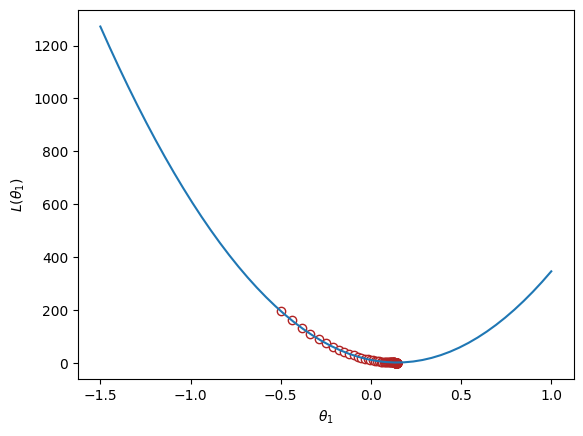

In [21]:
#| fig-alt: "A curve representing the loss is shown with different guesses converging to the global minimum. The plot is titled 'Final guess for theta_1: 0.14369554654231262'"
def gradient_descent(df, initial_guess, alpha, n):
    """Performs n steps of gradient descent on df using learning rate alpha starting
       from initial_guess. Returns a numpy array of all guesses over time."""
    guesses = [initial_guess]
    current_guess = initial_guess
    while len(guesses) < n:
        current_guess = current_guess - alpha * df(current_guess)
        guesses.append(current_guess)
        
    return np.array(guesses)

def mse_single_arg(theta_1):
    """Returns the MSE on our data for the given theta1"""
    x = df["total_bill"]
    y_obs = df["tip"]
    y_hat = theta_1 * x
    return np.mean((y_hat - y_obs) ** 2)

def mse_loss_derivative_single_arg(theta_1):
    """Returns the derivative of the MSE on our data for the given theta1"""
    x = df["total_bill"]
    y_obs = df["tip"]
    y_hat = theta_1 * x
    
    return np.mean(2 * (y_hat - y_obs) * x)

loss_df = pd.DataFrame({"theta_1":np.linspace(-1.5, 1), "MSE":[mse_single_arg(theta_1) for theta_1 in np.linspace(-1.5, 1)]})

trajectory = gradient_descent(mse_loss_derivative_single_arg, -0.5, 0.0001, 100)

plt.plot(loss_df["theta_1"], loss_df["MSE"])
plt.scatter(trajectory, [mse_single_arg(guess) for guess in trajectory], c="white", edgecolor="firebrick")
plt.scatter(trajectory[-1], mse_single_arg(trajectory[-1]), c="firebrick")
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$L(\theta_1)$");

print(f"Final guess for theta_1: {trajectory[-1]}")